# EDA

In [18]:
# EDA
# Cell: 0 — Imports, global plotting style, and helper functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json

# plotting defaults for high quality
sns.set(style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 12,
    "figure.figsize": (10,5)
})


FIG_DIR = Path("../asset/eda_figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(fname):
    p = FIG_DIR / fname
    plt.tight_layout()
    plt.savefig(p, dpi=300, bbox_inches='tight')
    print("Saved:", p)



In [19]:
df = pd.read_csv("/Users/ravigurjar/Desktop/temp/sample/dessertation/data/cleaned/final_df.csv")

In [20]:
df.head()

,timestamp,latitude,longitude,pm25_ugm3,co_ppm,no2_ppb,so2_ppb,o3_ppb,temperature_c,relative_humidity,wind_speed_ms,wind_direction_deg,aqi_value
0,2024-05-01 09:00:00,14.675886,77.593027,75.0,7.2,4.7,3.6,6.8,35.22,33.79,3.94,259.8,75
1,2024-05-01 05:00:00,16.987287,81.736318,5.0,5.8,1.1,4.7,6.5,34.87,52.86,4.19,202.5,19
2,2024-05-01 10:00:00,13.670000,79.350000,90.0,7.3,10.0,4.1,12.5,35.10,46.06,4.31,176.7,90
3,2020-11-19 16:00:00,16.507014,80.627767,52.0,4.2,0.7,4.9,5.1,24.94,87.03,2.44,109.8,-
4,2024-05-01 10:00:00,27.103358,93.679645,127.0,2.8,1.1,1.7,1.0,25.98,66.55,3.14,222.0,127


In [21]:
df.columns

Index(['timestamp', 'latitude', 'longitude', 'pm25_ugm3', 'co_ppm', 'no2_ppb',
       'so2_ppb', 'o3_ppb', 'temperature_c', 'relative_humidity',
       'wind_speed_ms', 'wind_direction_deg', 'aqi_value'],
      dtype='object')

## Missing value

In [22]:
df.isnull().sum()


timestamp              12
latitude                0
longitude               0
pm25_ugm3             179
co_ppm                349
no2_ppb               259
so2_ppb               315
o3_ppb                354
temperature_c          12
relative_humidity      12
wind_speed_ms          12
wind_direction_deg     12
aqi_value               0
dtype: int64

Saved: ../asset/eda_figs/step01_missing_heatmap.png


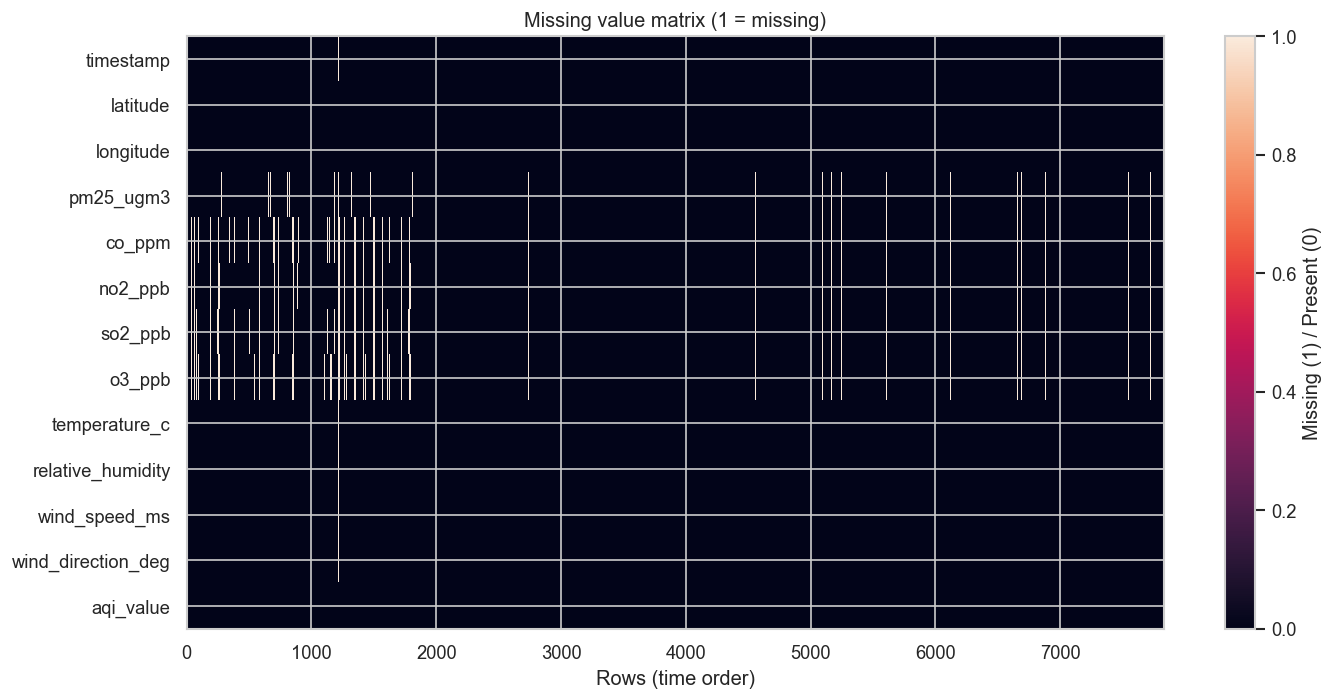

In [23]:
# Step 1: Missing heatmap
mv = df.isna().astype(int)
plt.figure(figsize=(12,6))
plt.imshow(mv.T, aspect='auto', interpolation='nearest')
plt.yticks(range(len(mv.columns)), mv.columns)
plt.xlabel("Rows (time order)")
plt.title("Missing value matrix (1 = missing)")
cbar = plt.colorbar()
cbar.set_label("Missing (1) / Present (0)")
savefig("step01_missing_heatmap.png")
plt.show()


### Step 3: Outlier Detection using IQR & Z-score
Flag extreme spikes for core pollutants (pm25_ugm3, no2_ppb, o3_ppb). We'll create boolean flags.

In [24]:
# Step 3: Outlier detection
polls = ['pm25_ugm3','no2_ppb','o3_ppb','co_ppm','so2_ppb']
outlier_flags = pd.DataFrame(index=df.index)

# IQR method
for col in polls:
    if col in df.columns:
        series = df[col].dropna()
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_flags[f'{col}_iqr_flag'] = ((df[col] < lower) | (df[col] > upper))
        # z-score extreme (|z|>3)
        zscores = np.abs(stats.zscore(df[col].dropna()))
        zmask = pd.Series(False, index=df.index)
        zmask.loc[series.index] = (zscores > 3)
        outlier_flags[f'{col}_z_flag'] = zmask

# summary
outlier_summary = outlier_flags.sum().sort_values(ascending=False)
display(outlier_summary)
outlier_flags.to_csv(FIG_DIR/"step03_outlier_flags.csv")
print("Saved outlier flags.")


co_ppm_iqr_flag       634
pm25_ugm3_iqr_flag    585
so2_ppb_iqr_flag      468
no2_ppb_iqr_flag      464
o3_ppb_iqr_flag       379
no2_ppb_z_flag        174
o3_ppb_z_flag         134
so2_ppb_z_flag        119
pm25_ugm3_z_flag       98
co_ppm_z_flag          88
dtype: int64

Saved outlier flags.


# SECTION B — Univariate Analysis

### Step 5: Distribution plots (Histogram + KDE) for core pollutants
We use log-scale where appropriate and compute skewness/kurtosis.


Saved: ../asset/eda_figs/step05_dist_pm25_ugm3.png


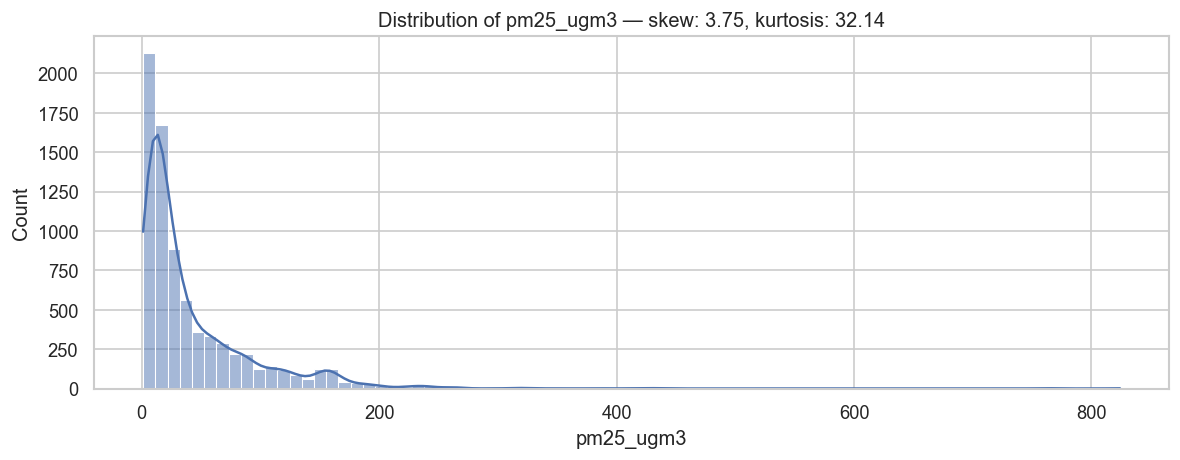

Saved: ../asset/eda_figs/step05_dist_co_ppm.png


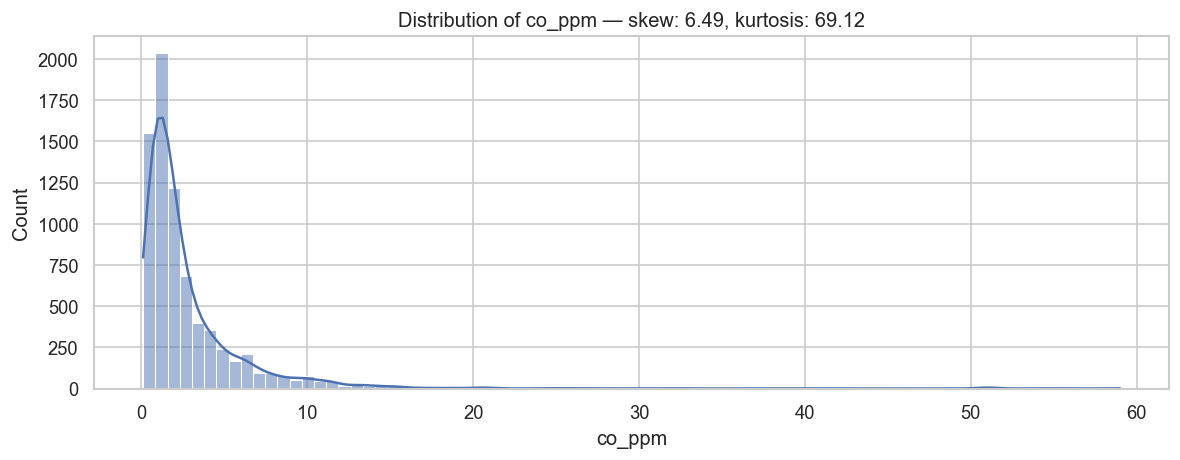

Saved: ../asset/eda_figs/step05_dist_no2_ppb.png


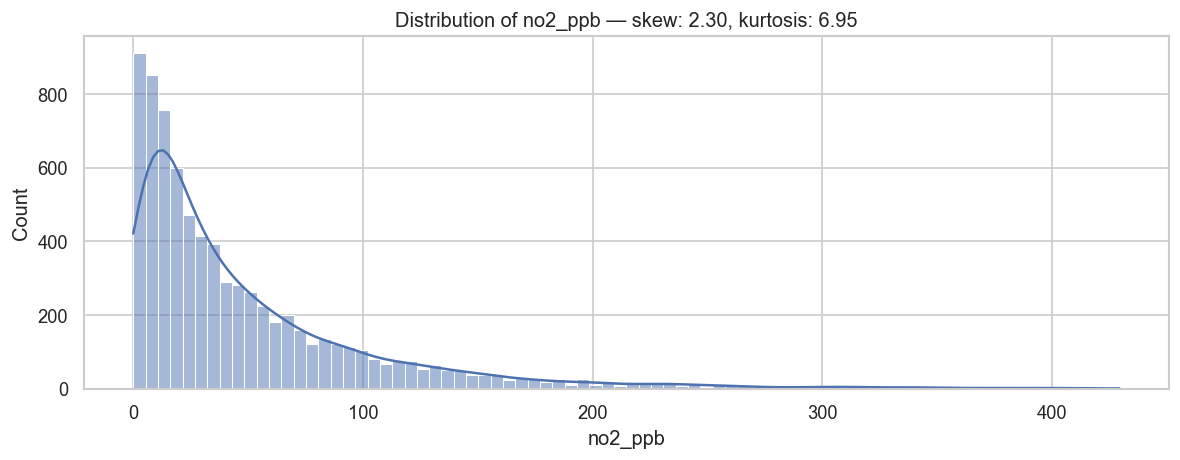

Saved: ../asset/eda_figs/step05_dist_o3_ppb.png


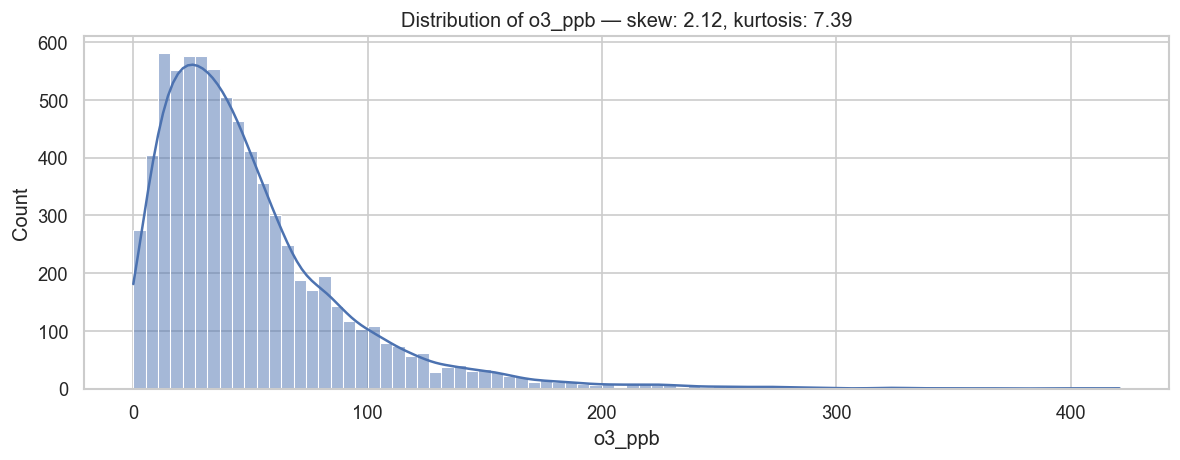

Saved: ../asset/eda_figs/step05_dist_so2_ppb.png


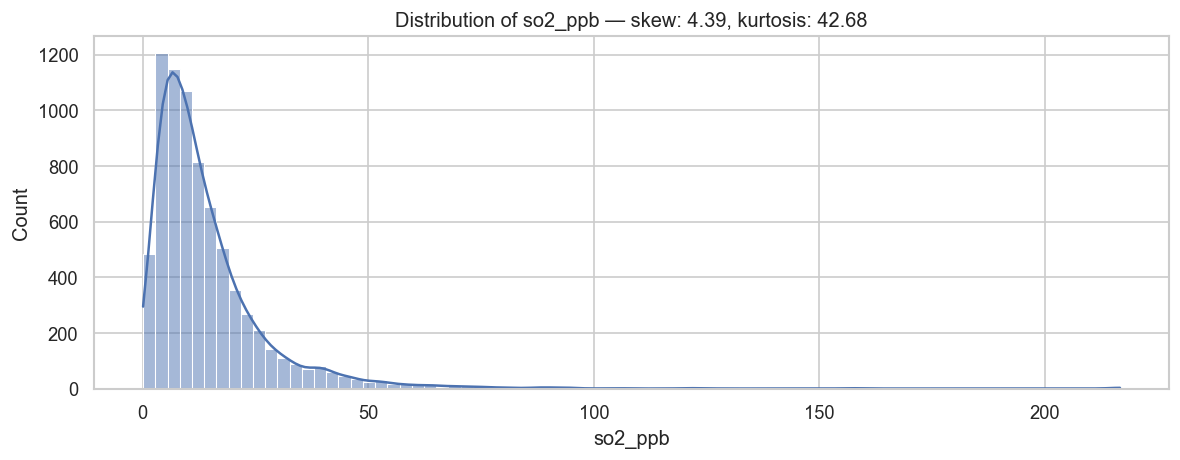

In [25]:
# Step 5: Distribution plots for statistical behavior
core_p = [c for c in ['pm25_ugm3','co_ppm','no2_ppb','o3_ppb','so2_ppb'] if c in df.columns]
for col in core_p:
    data = df[col].dropna()
    plt.figure(figsize=(10,4))
    sns.histplot(data, kde=True, bins=80)
    plt.xlabel(col)
    plt.title(f"Distribution of {col} — skew: {data.skew():.2f}, kurtosis: {data.kurtosis():.2f}")
    savefig(f"step05_dist_{col}.png")
    plt.show()


### Step 6: Boxplots to identify extreme pollution events
Boxplot side-by-side for quick comparison across pollutants.


Saved: ../asset/eda_figs/step06_boxplots_core_pollutants.png


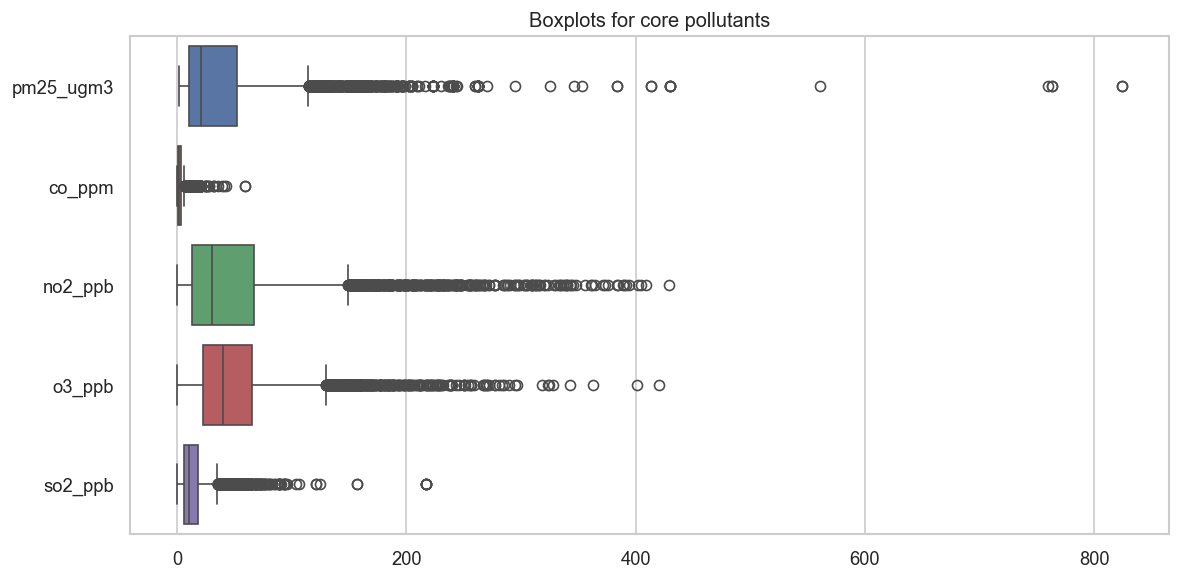

In [26]:
# Step 6: Boxplots
plt.figure(figsize=(10,5))
sns.boxplot(data=df[core_p].dropna(), orient='h')
plt.title("Boxplots for core pollutants")
savefig("step06_boxplots_core_pollutants.png")
plt.show()


# SECTION C — Time-Series Diagnostics

### Step 8: Line plots of core variables (time-series)
Plot multi-panel time series for pollutants and key meteorology variables.


Saved: ../asset/eda_figs/step08_timeseries_panels.png


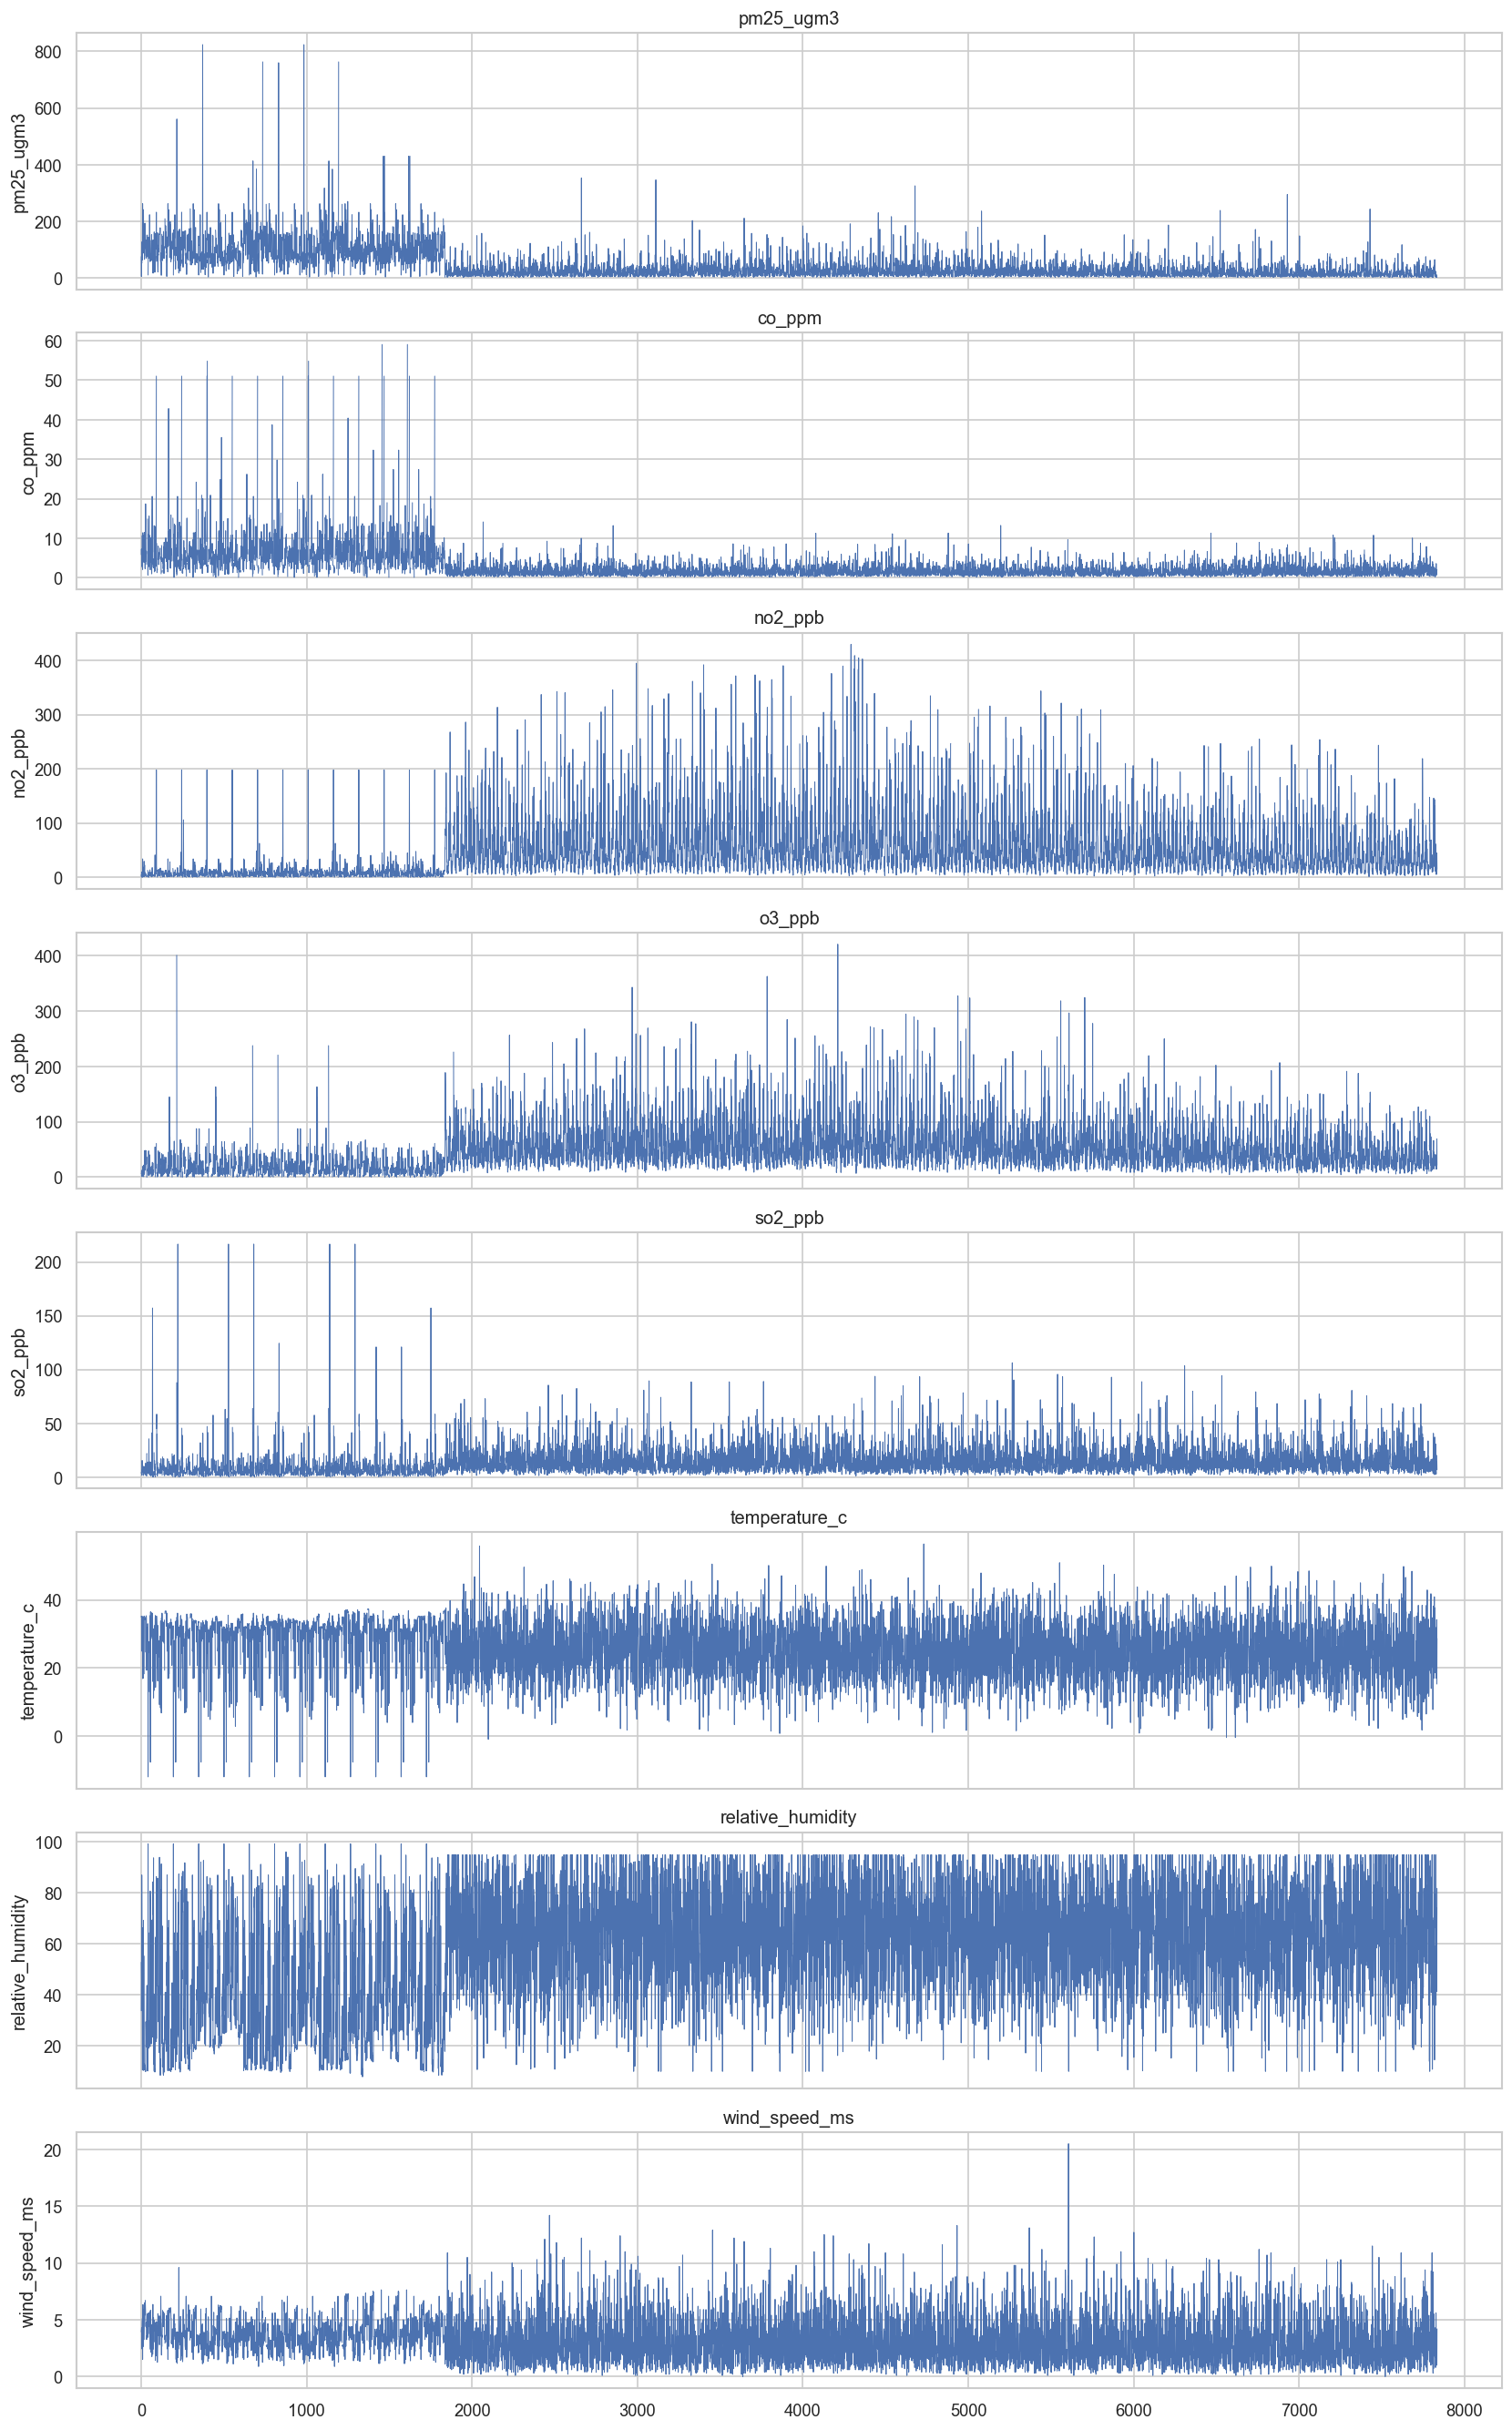

In [27]:
    # Step 8: Multi-panel time series
vars_ts = core_p + [c for c in ['temperature_c','relative_humidity','wind_speed_ms'] if c in df.columns]
plt.figure(figsize=(14,2.8*len(vars_ts)))
for i, col in enumerate(vars_ts, 1):
    ax = plt.subplot(len(vars_ts),1,i)
    plt.plot(df.index, df[col], linewidth=0.6)
    plt.title(col)
    plt.ylabel(col)
    if i < len(vars_ts):
        ax.set_xticklabels([])
savefig("step08_timeseries_panels.png")
plt.show()


# SECTION D — Multivariate Analysis

### Step 11: Correlation matrix (Pearson + Spearman)
Show correlations with a heatmap and annotate top relationships.


Saved: ../asset/eda_figs/step11_corr_pearson.png


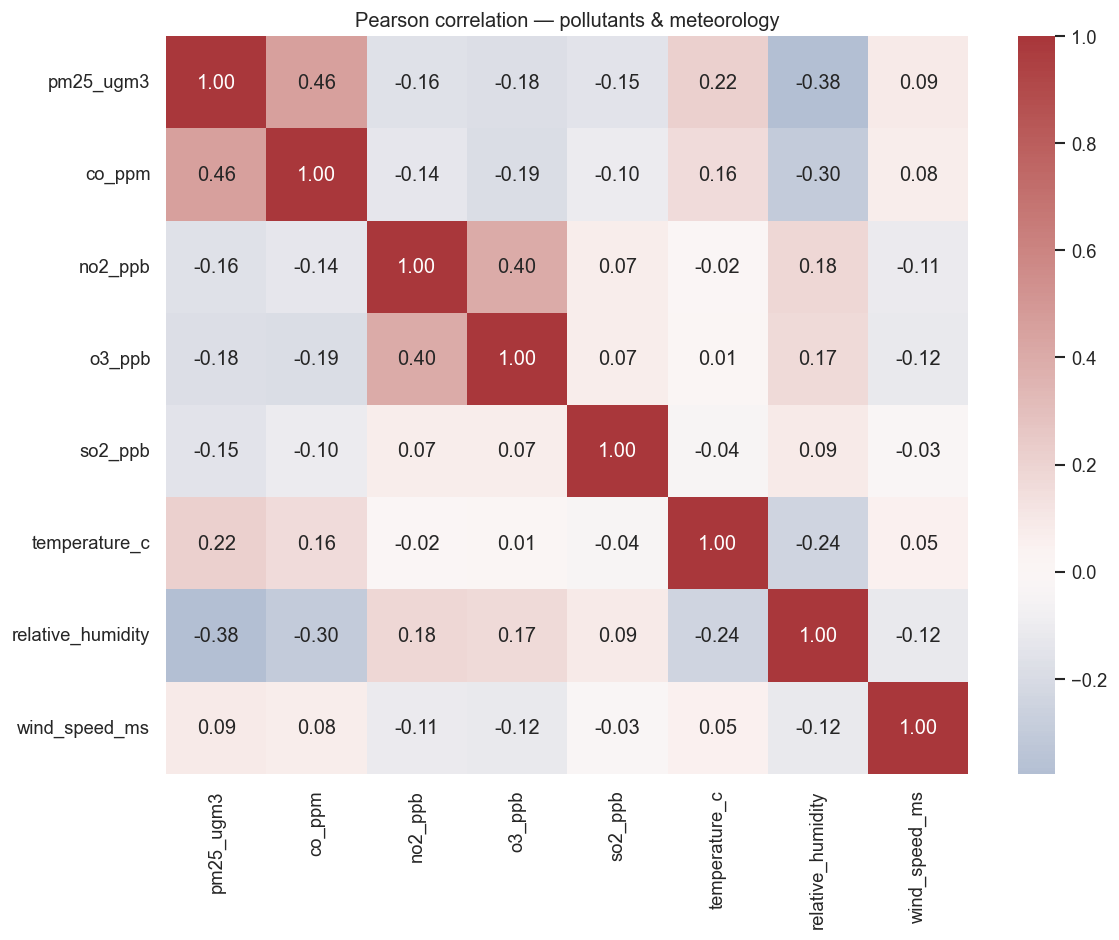

Saved: ../asset/eda_figs/step11_corr_spearman.png


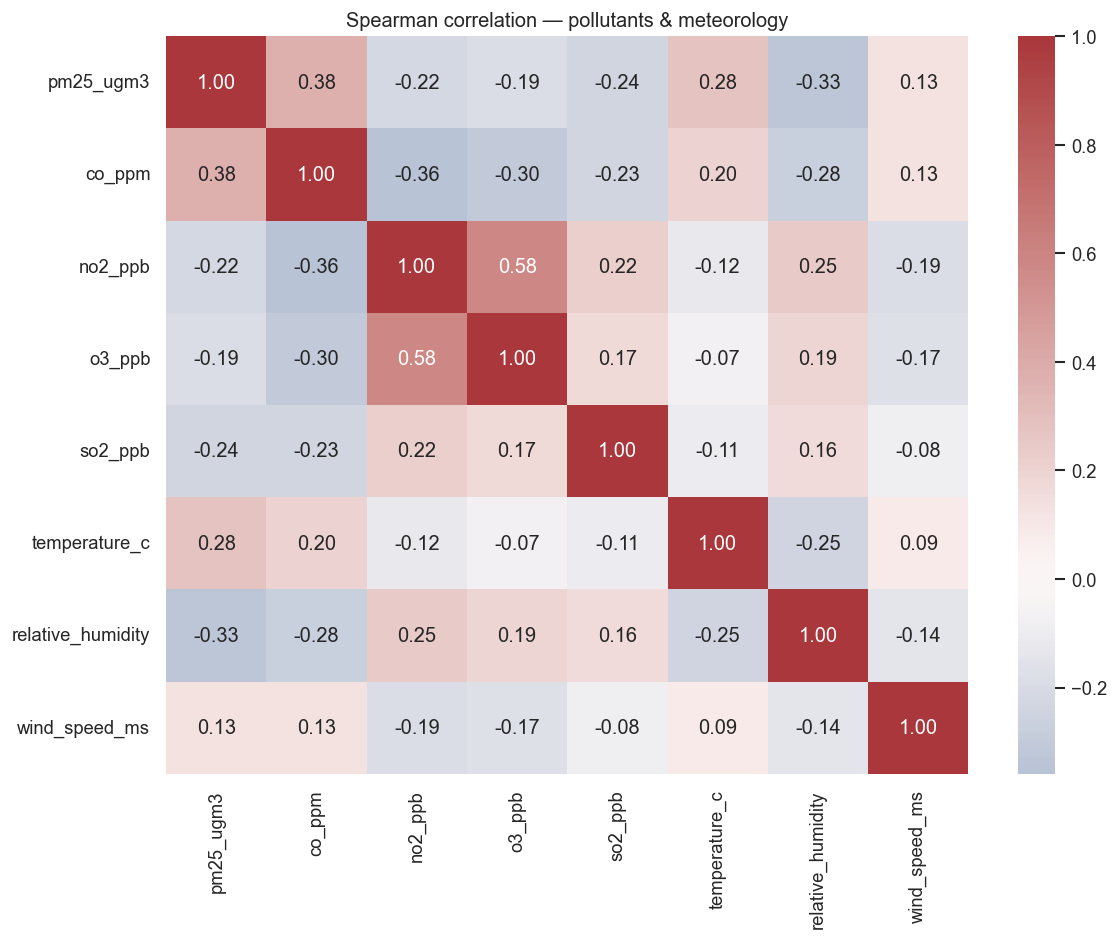

In [28]:
# Step 11: Correlation matrices
analysis_cols = core_p + [c for c in ['temperature_c','relative_humidity','wind_speed_ms'] if c in df.columns]
corr_pear = df[analysis_cols].corr(method='pearson')
corr_spear = df[analysis_cols].corr(method='spearman')

plt.figure(figsize=(10,8))
sns.heatmap(corr_pear, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Pearson correlation — pollutants & meteorology")
savefig("step11_corr_pearson.png")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(corr_spear, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Spearman correlation — pollutants & meteorology")
savefig("step11_corr_spearman.png")
plt.show()


### Step 12: Pollutant vs Weather scatterplots with regression lines
Examples: PM2.5 vs Wind speed, PM2.5 vs Temperature, NO2 vs Wind speed/direction.


Saved: ../asset/eda_figs/step12_scatter_pm25_ugm3_vs_wind_speed_ms.png


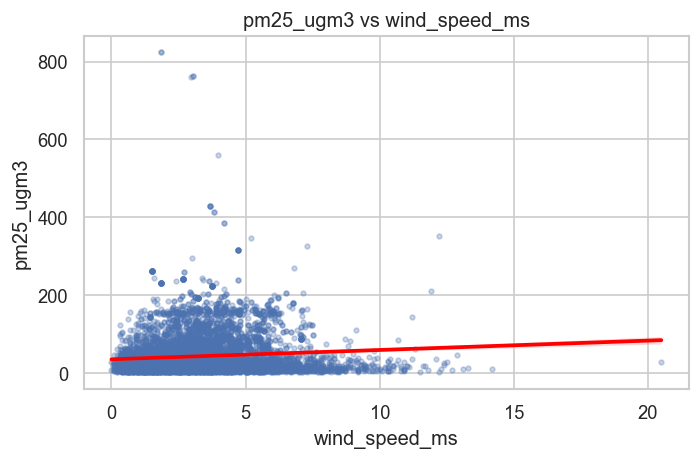

Saved: ../asset/eda_figs/step12_scatter_pm25_ugm3_vs_temperature_c.png


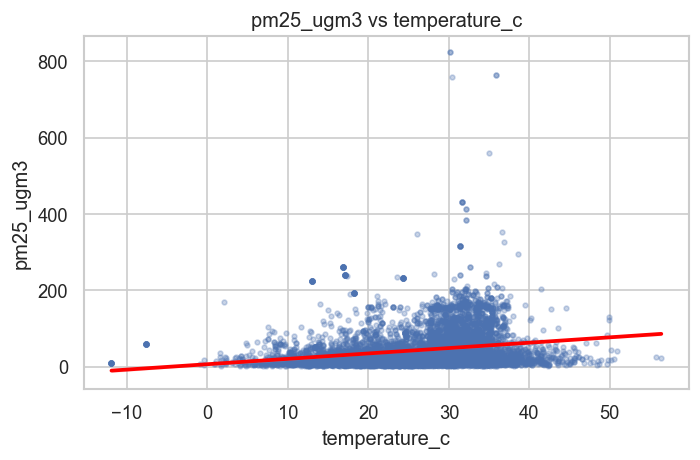

Saved: ../asset/eda_figs/step12_scatter_no2_ppb_vs_wind_speed_ms.png


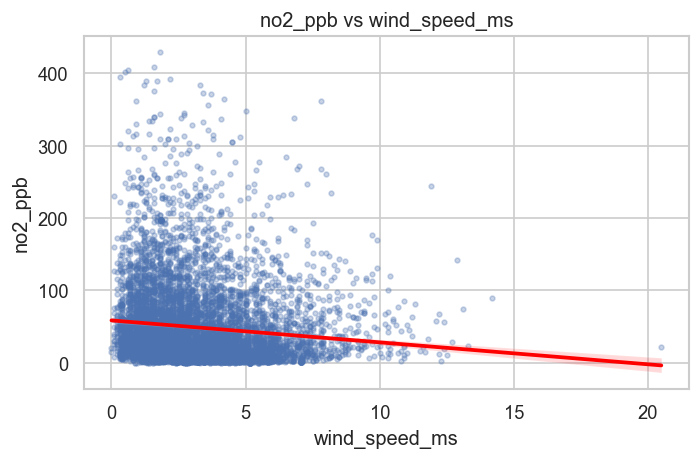

In [29]:
# Step 12: Scatter + regression
pairs = [('pm25_ugm3','wind_speed_ms'), ('pm25_ugm3','temperature_c'), ('no2_ppb','wind_speed_ms')]
for x,y in pairs:
    if x in df.columns and y in df.columns:
        plt.figure(figsize=(6,4))
        sns.regplot(x=df[y], y=df[x], scatter_kws={'s':8, 'alpha':0.3}, line_kws={'color':'red'})
        plt.xlabel(y); plt.ylabel(x)
        plt.title(f"{x} vs {y}")
        savefig(f"step12_scatter_{x}_vs_{y}.png")
        plt.show()


### Step 13: Wind rose plot (pollution vs wind direction)
Aggregate pollutant concentration by wind-direction bins and plot radial bar chart.


/var/folders/zz/x6f9575d2lgc_whh727t8y4c0000gn/T/ipykernel_29137/343884379.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rose = tmp.groupby('dir_bin')['pm25_ugm3'].mean().astype(float)


Saved: ../asset/eda_figs/step13_wind_rose_pm25.png


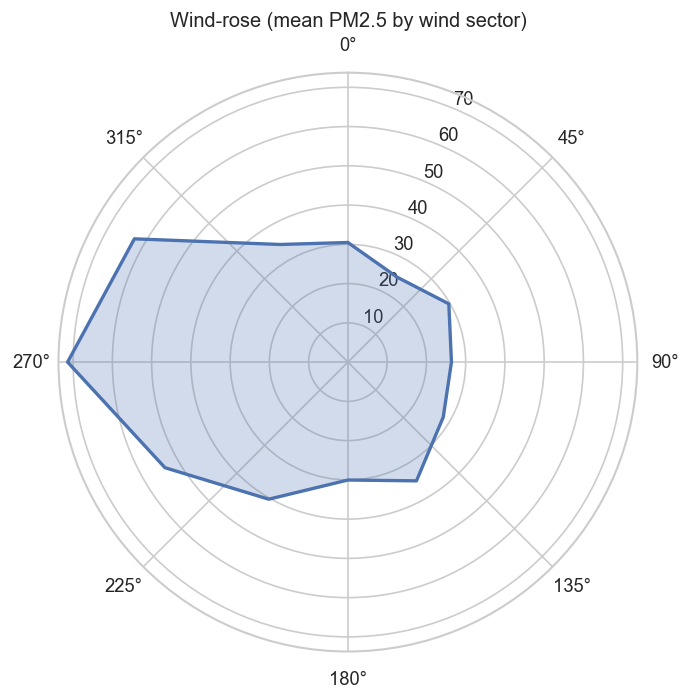

In [30]:
# Step 13: Wind rose-like polar plot for pm25_ugm3
if 'wind_direction_deg' in df.columns and 'pm25_ugm3' in df.columns:
    tmp = df[['wind_direction_deg','pm25_ugm3']].dropna()
    bins = np.arange(0,361,30)  # 12 sectors
    tmp['dir_bin'] = pd.cut(tmp['wind_direction_deg'], bins=bins, right=False, labels=bins[:-1])
    rose = tmp.groupby('dir_bin')['pm25_ugm3'].mean().astype(float)
    # prepare for polar plot
    angles = np.deg2rad(np.append(rose.index.astype(float), 360))
    values = np.append(rose.values, rose.values[0])
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, values, 'b-', linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title("Wind-rose (mean PM2.5 by wind sector)")
    savefig("step13_wind_rose_pm25.png")
    plt.show()
else:
    print("Wind direction or pm25 missing.")


# SECTION E — Label & AQI Analysis


### Step 15: Class distribution of `binary_label`
Inspect balance of Safe vs Harmful for modelling decisions.


In [31]:
# Step 15: Class distribution
if 'binary_label' in df.columns:
    counts = df['binary_label'].value_counts()
    plt.figure(figsize=(6,4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.ylabel("Count")
    plt.title("Distribution of binary_label")
    savefig("step15_binary_label_dist.png")
    plt.show()
    print(counts)
else:
    print("binary_label not found")


binary_label not found


### Step 16: Pollutant levels by AQI category
Boxplots / violin plots of pollutants grouped by `aqi_category`.

In [32]:
# Step 16: Pollutant levels by AQI category
if 'aqi_category' in df.columns:
    cats = df['aqi_category'].unique()
    for col in core_p:
        plt.figure(figsize=(10,4))
        sns.boxplot(x='aqi_category', y=col, data=df.reset_index(), order=sorted(cats))
        plt.xticks(rotation=45)
        plt.title(f"{col} by AQI category")
        savefig(f"step16_{col}_by_aqi_cat.png")
        plt.show()
else:
    print("aqi_category not present.")



aqi_category not present.


### Step 17: Feature importance baseline (Random Forest)
Train quick RF to predict `binary_label` and show top features (baseline).


In [33]:
# Step 17: RF baseline feature importance
if 'binary_label' in df.columns:
    # Prepare data — use core_p + meteorology
    feat_cols = [c for c in core_p + ['temperature_c','relative_humidity','wind_speed_ms'] if c in df.columns]
    tmp = df[feat_cols + ['binary_label']].dropna()
    X = tmp[feat_cols].fillna(0)
    y = tmp['binary_label']
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=42)
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=feat_cols).sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=importances.values, y=importances.index)
    plt.title("RandomForest feature importances")
    savefig("step17_rf_feature_importance.png")
    plt.show()
    display(importances)
else:
    print("binary_label missing — cannot train RF baseline.")


binary_label missing — cannot train RF baseline.
